# Developing different trading strategies
In this notebook different trading strategies will be developed 


## Setup
All the different imports and constants are getting defined

In [19]:
import math
from matplotlib import gridspec
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM 
import matplotlib as mpl
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow import keras

import tensorflow as tf
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.timeseries import TimeSeries
from datetime import *
plt.tight_layout()

Stock = "AAPL"
API_KEY = "2K412SNOUGH30X5E"
observation_time = 60
future_time = 1
training_start_date = datetime(2015, 10, 1)
training_end_date = datetime(2020, 1, 1)

# Percent of set
training_set_size = 64/100;
validation_set_size = 16/100;
test_set_size = 20/100

feature_size = 60

<Figure size 432x288 with 0 Axes>

# Defining the simulated enviroment
A trading enviroment is getting defined. SockManger interacts with the different strategies and proviede basic methods as Buy and sell stocks. History Manager keeps track over time in order to display the past. DataManager downloads the data and proviedes it. TradeMaker uses the devined classes and builds the simulated enviroment 

In [20]:
class StockManager:
    def __init__(self, my_money):
        self.my_money = my_money
        self.my_inital_money = my_money
        self.amount_of_stocks = 0
        # the money that was used to buy a stock (was risked to lose it...)
        self.invested_money = 0
        self.money_was_invested = 0
    
    def buy_stock(self, current_stock_price):
        if ( self.my_money > current_stock_price ):
            self.my_money -= current_stock_price
            self.amount_of_stocks += 1
            
            if self.money_was_invested >= current_stock_price:
                self.money_was_invested -= current_stock_price
            else:
                self.invested_money += ( current_stock_price - self.money_was_invested)
                self.money_was_invested = 0
    
    def reset(self):
        self.my_money = self.my_inital_money
        self.amount_of_stocks = 0
        self.invested_money = 0
        self.money_was_invested = 0
        
    def price_per_stock(self):
        if self.amount_of_stocks == 0:
            return 0
        return (self.invested_money - self.money_was_invested)/self.amount_of_stocks

    def sell_stock(self, current_stock_price):
        if ( self.amount_of_stocks >= 1 ):
            self.my_money += current_stock_price
            self.amount_of_stocks -= 1
            
            self.money_was_invested += current_stock_price
            
    def get_current_winnings(self, current_stock_price):
        return self.my_money + self.amount_of_stocks * current_stock_price - self.my_inital_money
    
    
    def get_current_winnings_in_percent(self, current_stock_price):
        if (self.invested_money == 0):
            return 0
        return self.get_current_winnings(current_stock_price)/self.invested_money

class HistoryMangaer:
    def __init__(self, labels=[]):
        self.reset()
        self.labels = labels
        
    def reset(self):
        self.winnings = []
        self.amount_of_stocks = []
        self.time = []
        self.stock_price = []
        self.buy_time_x = []
        self.buy_time_y = []
        self.sell_time_x = []
        self.sell_time_y = []
        self.winning_trades = 0
        self.loosing_trades = 0
        self.params = {}
    
    def add_point_in_history(self, stock_manager, time, current_stock_price, **params):
        datapoints = len(self.amount_of_stocks)
        if ( datapoints > 0 ):
            if (stock_manager.amount_of_stocks > self.amount_of_stocks[datapoints-1] ):
                self.buy_time_x.append(time)
                self.buy_time_y.append(current_stock_price)
                print("Buy Date: " + str(time))
            if (stock_manager.amount_of_stocks < self.amount_of_stocks[datapoints-1] ):
                self.sell_time_x.append(time)
                self.sell_time_y.append(current_stock_price)
                print("Sell Date: " + str(time))
                if current_stock_price > self.buy_time_y[-1]:
                    self.winning_trades += 1
                else:
                    self.loosing_trades += 1
        for key, value in params.items():
            if not key in self.params:
                self.params[key] = [value]
            else:
                self.params[key].append(value)
            
        self.winnings.append(stock_manager.get_current_winnings(current_stock_price) +  stock_manager.my_inital_money)
        self.amount_of_stocks.append(stock_manager.amount_of_stocks)
        self.stock_price.append(current_stock_price)
        self.time.append(time)
        
    def get_sharpe_ratio(self,data):
        R = pd.DataFrame(data)
        r = R.diff()
        sr = r.mean()-0.000168/(R.pct_change().std() * np.sqrt(252))
        number_of_periodes = len(r)/252
        #print(number_of_periodes)
        winnings = data[-1]/data[0]
        #print(winnings)
        cagr = pow(winnings,1/number_of_periodes)-1 
        risk_free_rate = 0.02
        sr = (cagr-risk_free_rate)/(R.pct_change().std() * np.sqrt(252))
        return sr
        
        
    def plot_history(self, plot=None):
        ploter = None
        if plot is None:
            plt.figure(figsize=(18,9))
            ploter = plt
        else:
            ploter = plot

        labels = self.time
        
        
        
        number_of_periodes = len(self.winnings)/252
        w = self.winnings[-1]/self.winnings[0]
        w_s = self.stock_price[-1]/self.stock_price[0]
        anual_return = pow(w,1/number_of_periodes)-1 
        anual_return_s = pow(w_s,1/number_of_periodes)-1 
        
        
        print("Sharp Ratio Stock: " + str(float(self.get_sharpe_ratio(self.stock_price)))) 
        print("Sharp Ratio Strategy: " + str(float(self.get_sharpe_ratio(self.winnings))))
        print("Anual return stock: " + str(anual_return_s*100) + "%") 
        print("Anual return: " + str(anual_return*100) + "%") 
        print("Winning trades: " + str(self.winning_trades))
        print("Loosing trades: " + str(self.loosing_trades))

        if len(self.labels) > 0:
            labels = self.labels[:len(self.time)]
            
        ploter.plot(labels, self.stock_price, ".-", label="Adjusted closing price")
        ploter.plot(labels, self.winnings, ".-", label="Winnings")
        ploter.plot(self.buy_time_x, self.buy_time_y, 'o',color='#00FF00',label="Buy")
        ploter.plot(self.sell_time_x, self.sell_time_y, 'o',color='#FF0000',label="Sell")
        if plot is None:
            ploter.xlabel("Date")
            ploter.ylabel("Closing Price")
        
        for key in self.params:
            ploter.plot(labels, self.params[key], ".-", label=key, color='#CCCCCC')
        
        ploter.legend(fontsize=14)
        ploter.legend(fontsize=14)
        ploter.grid(b=True, which='major',color='#CCCCCC')
        ploter.minorticks_on()
        ploter.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
        if plot is None:
            ploter.show()
        
class DataManager:
    def __init__(self, stock_symbol, end_date, start_date="", scale=False):
        self.stock_symbol = stock_symbol
        self.end_date = end_date
        self.start_date = start_date
        self.scale = scale
        self.scale_factor = 1
        self.getting_data()
        self.scaler = MinMaxScaler(feature_range=(0,1))
        
    def getting_data(self):
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        self.raw_stock_data, meta_data = ts.get_daily_adjusted(symbol=self.stock_symbol, outputsize='full')
        if self.start_date == "":
            self.raw_stock_data = self.raw_stock_data.loc[self.end_date:]
        else:
            self.raw_stock_data = self.raw_stock_data.loc[self.end_date:self.start_date]
        

        adjusted_close_data = self.raw_stock_data.filter(["5. adjusted close"]).values
        adjusted_close_data = np.flip(adjusted_close_data)
        open_data = self.raw_stock_data.filter(["1. open"]).values
        open_data = np.flip(open_data)
        low_data = self.raw_stock_data.filter(["3. low"]).values
        low_data = np.flip(low_data)
        high_data = self.raw_stock_data.filter(["2. high"]).values
        high_data = np.flip(high_data)
        close_data = self.raw_stock_data.filter(["4. close"]).values
        close_data = np.flip(close_data)
        
        vol_data = self.raw_stock_data.filter(["6. volume"]).values
        vol_data = np.flip(close_data)
        
        self.date_key = np.flip(self.raw_stock_data["5. adjusted close"].keys())
        tmp_data = []
        
        if (self.scale):
            for i in range(0, len(open_data)):
                adjusted_factor = adjusted_close_data[i][0] / close_data[i][0]
                self.scale_factor = max(self.scale_factor,high_data[i][0]* adjusted_factor)
        
        for i in range(0, len(open_data)):
            adjusted_factor = adjusted_close_data[i][0] / close_data[i][0]
            tmp_data.append({
                "open": (open_data[i][0] * adjusted_factor)/self.scale_factor,
                "adjusted_close": (adjusted_close_data[i][0])/self.scale_factor,
                "close": (close_data[i][0] * adjusted_factor)/self.scale_factor,
                "high": (high_data[i][0]* adjusted_factor)/self.scale_factor,
                "low": (low_data[i][0] * adjusted_factor)/self.scale_factor,
                "data": self.date_key[i],
                "vol": vol_data[i][0]
            })

        self.raw_stock_data = tmp_data

        
class TradeMaker:
    def __init__(self, stock_symbol, money,  end_date, start_date="", start_day=0, scale = False):
        self.data_manager = DataManager(stock_symbol, end_date, start_date,scale)
        self.start_day = start_day
        self.current_day = start_day
        self.max_number_of_days = len(self.data_manager.raw_stock_data)
        self.date_keys = self.data_manager.date_key[start_day:]
        self.history_manager = HistoryMangaer(self.date_keys)
        self.stock_manager = StockManager(money)
        self.stop_market_order_price = 0
        self.stop_market_order_amount = 0
        self.active_stop_market_order = False
        self.last_buy_price = 0
        
    def reset(self):
        self.current_day = self.start_day
        self.max_number_of_days = len(self.data_manager.raw_stock_data)
        self.stop_market_order_price = 0
        self.stop_market_order_amount = 0
        self.active_stop_market_order = False
        self.last_buy_price = 0
        
        
    def is_invested(self):
        return self.stock_manager.amount_of_stocks != 0
        
    def get_historical_data(self, days, price_type):
        data = self.data_manager.raw_stock_data[max(self.current_day-days,0):self.current_day]
        return_value = []
        for prices in data:
            return_value.append(prices[price_type])
        return return_value
        
            
    def current_date(self):
        return self.data_manager.date_key[self.current_day]
        
        
    def stop_market_order(self, price, amount=0):
        self.stop_market_order_price = price
        self.stop_market_order_amount = amount
        self.active_stop_market_order = True

    def cancel_stop_market_order(self):
        self.active_stop_market_order = False
        
    def next_day(self, **params):
        # Check the pending stop marked orders
        if self.active_stop_market_order:
            low = self.data_manager.raw_stock_data[self.current_day]["low"]
            high = self.data_manager.raw_stock_data[self.current_day]["high"]
            
            
            if self.stop_market_order_price > low and self.stop_market_order_price < high:
                self.stock_manager.sell_stock(self.stop_market_order_price)
                self.active_stop_market_order = False

        self.history_manager.add_point_in_history(self.stock_manager,self.current_date(),self.todays_price()["close"],**params)
        yesterdays_close = self.todays_price()["close"]
        self.current_day += 1
        done = False
        if ( self.current_day >= self.max_number_of_days ):
            done = True
        elif(self.active_stop_market_order == True):
            today_open = self.todays_price()["open"]
            if self.stop_market_order_price > min(today_open,yesterdays_close) and self.stop_market_order_price < max(today_open,yesterdays_close):
                self.stock_manager.sell_stock(self.stop_market_order_price)
                self.active_stop_market_order = False
        return done
        
    def todays_price(self):
        return self.data_manager.raw_stock_data[self.current_day]
    
    def buy(self):
        self.stock_manager.buy_stock(self.todays_price()["open"])
        self.last_buy_price = self.todays_price()["open"]

    def sell(self):
        self.stock_manager.sell_stock(self.todays_price()["open"])
        
        
    def get_current_features(self):
        current_stock_price = self.todays_price()["open"]
        next_prices = self.predictions[self.current_controll_var()]
        return [self.stock_manager.amount_of_stocks, current_stock_price, self.stock_manager.price_per_stock(), next_prices[0] ]
    
    def plot(self, ploter=None):
        self.history_manager.plot_history(ploter)

    def winnings(self):
        return self.stock_manager.get_current_winnings(self.todays_price()["open"])
    
    def stock_increasement(self):
        return (self.todays_price()["open"] - self.history_manager.stock_price[0])/self.history_manager.stock_price[0]
    
    def get_current_winnings_in_percent(self):
        return self.stock_manager.get_current_winnings_in_percent(self.todays_price()["open"])
    
    def get_reward(self):
        stock_winnings = (self.todays_price()["open"] - self.history_manager.stock_price[0])/self.history_manager.stock_price[0]
        if stock_winnings < 0:
            stock_winnings = 0
        return self.get_current_winnings_in_percent() - stock_winnings



## Developing different methods
Now different methods are getting developed. First the TradeMaker is getting defined

In [21]:

t = TradeMaker("AAPL",25,"2016-11-21", "2013-06-27",32)

In order to have a base to compare a monky trader is getting defined that buys and sells stocks random 

Buy Date: 2013-08-14 00:00:00
Sell Date: 2013-08-16 00:00:00
Buy Date: 2013-08-19 00:00:00
Sell Date: 2013-08-21 00:00:00
Buy Date: 2013-08-23 00:00:00
Sell Date: 2013-09-03 00:00:00
Buy Date: 2013-09-04 00:00:00
Sell Date: 2013-09-06 00:00:00
Buy Date: 2013-09-24 00:00:00
Sell Date: 2013-10-09 00:00:00
Buy Date: 2013-10-10 00:00:00
Sell Date: 2013-10-11 00:00:00
Buy Date: 2013-10-14 00:00:00
Sell Date: 2013-10-16 00:00:00
Buy Date: 2013-10-18 00:00:00
Sell Date: 2013-10-22 00:00:00
Buy Date: 2013-11-01 00:00:00
Sell Date: 2013-11-05 00:00:00
Buy Date: 2013-11-06 00:00:00
Sell Date: 2013-11-11 00:00:00
Buy Date: 2013-11-22 00:00:00
Sell Date: 2013-12-10 00:00:00
Buy Date: 2013-12-17 00:00:00
Sell Date: 2013-12-18 00:00:00
Buy Date: 2013-12-27 00:00:00
Sell Date: 2013-12-30 00:00:00
Buy Date: 2014-01-03 00:00:00
Sell Date: 2014-01-06 00:00:00
Buy Date: 2014-01-08 00:00:00
Sell Date: 2014-01-13 00:00:00
Buy Date: 2014-01-14 00:00:00
Sell Date: 2014-01-16 00:00:00
Buy Date: 2014-01-17 00:

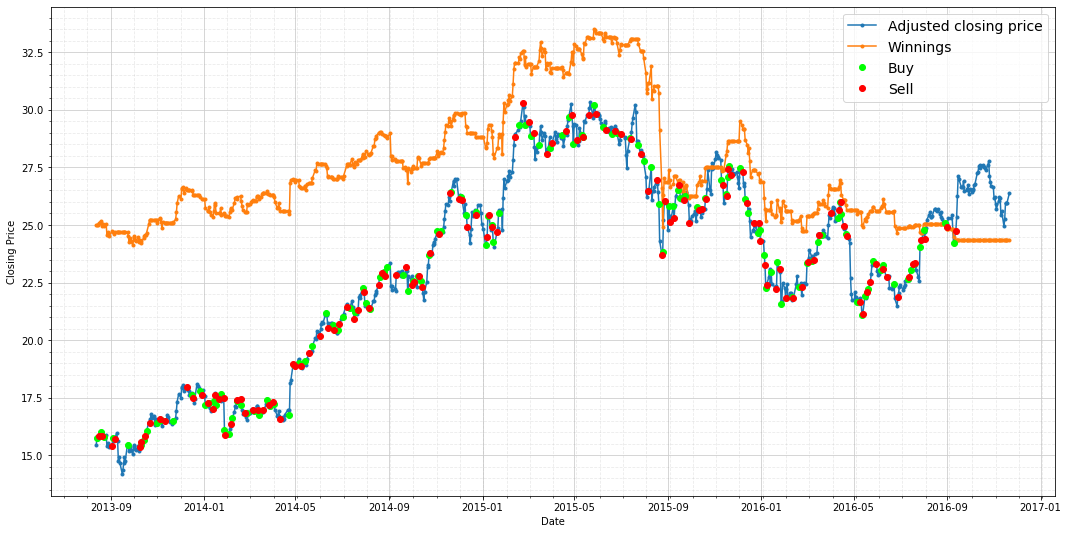

In [22]:
done = False
t.reset()
t.history_manager.reset()
t.stock_manager.reset()
t.next_day()
t.buy()
t.stop_market_order(30)
t.next_day()
while done != True:
    move = np.random.randint(3)
    if move == 0:
        t.sell()
    if not t.is_invested() and move == 2:
        t.buy()
    done = t.next_day()
t.plot()
t.current_day = 0
t.history_manager.reset()
t.stock_manager.reset()

## Momentum strategy 

In the next section two different momentum strategies are getting defined 

### Breakout strategy

Buy Date: 2013-08-14 00:00:00
Sell Date: 2013-08-27 00:00:00
Buy Date: 2013-10-16 00:00:00
Sell Date: 2014-01-28 00:00:00
Buy Date: 2014-03-26 00:00:00
Sell Date: 2014-03-27 00:00:00
Buy Date: 2014-04-25 00:00:00
Sell Date: 2014-12-09 00:00:00
Buy Date: 2015-01-29 00:00:00
Sell Date: 2015-03-11 00:00:00
Buy Date: 2015-04-23 00:00:00
Sell Date: 2015-04-30 00:00:00
Buy Date: 2015-07-21 00:00:00
Sell Date: 2015-07-22 00:00:00
Buy Date: 2015-10-29 00:00:00
Sell Date: 2015-11-11 00:00:00
Buy Date: 2016-03-02 00:00:00
Sell Date: 2016-04-27 00:00:00
Buy Date: 2016-07-15 00:00:00
Sell Date: 2016-07-25 00:00:00
Buy Date: 2016-07-28 00:00:00
Sell Date: 2016-11-04 00:00:00
Sharp Ratio Stock: 0.6475976568682366
Sharp Ratio Strategy: 0.6484735270392217
Anual return stock: 17.66898366050549%
Anual return: 8.69720931729856%
Winning trades: 4
Loosing trades: 7


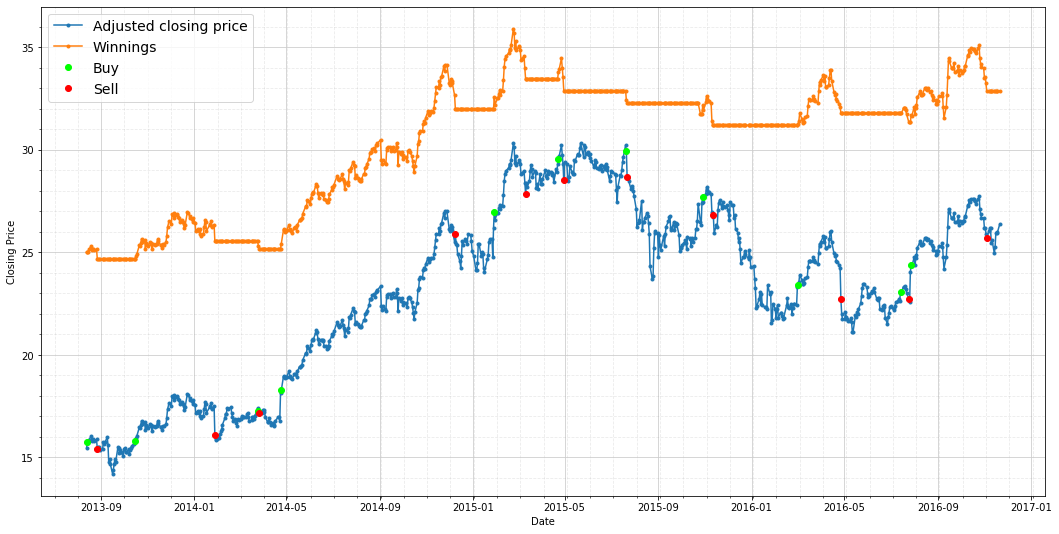

In [24]:
done = False
t.reset()
t.history_manager.reset()
t.stock_manager.reset()
max_lookback = 40
min_lookback = 20
lookback = 30

security_sell = 0.98
security_sell_price = 0
sell = 0.92
highest_price = 0

while done != True:
    closing_prices = t.get_historical_data(31,"close")
    volatility_today = np.std(closing_prices[1:31])
    volatility_yesterday = np.std(closing_prices[0:30])
    diff_v = (volatility_today - volatility_yesterday)/volatility_today
    lookback = min(max(int(round(lookback * (1 + diff_v))),min_lookback),max_lookback)
    highs = t.get_historical_data(lookback,"high")
    highest_high = max(highs[:-1])
    if not t.is_invested() and highest_high < closing_prices[-1]:
        t.buy()
        security_sell_price = t.todays_price()["open"] * security_sell
        t.stop_market_order(security_sell_price)
        highest_price = highest_high
    if t.is_invested() and closing_prices[-1] > highest_price:
        highest_price = closing_prices[-1]
        sell_price = closing_prices[-1] * sell
        if ( sell_price > security_sell_price ):
            t.stop_market_order(sell_price)
    
    
    done = t.next_day()
    

t.plot()
t.current_day = 0
t.history_manager.reset()
t.stock_manager.reset()

In [25]:
tmp = [1,2,3,4,5,6,7,8]

print( tmp[-8:])
print( tmp[7])
print( tmp[-1])
print( tmp[1:])

huber = {}
huber["test"] = 2
hasattr(huber, 'test')
"tesdt" in huber

[1, 2, 3, 4, 5, 6, 7, 8]
8
8
[2, 3, 4, 5, 6, 7, 8]


False

## MACD

Buy Date: 2013-08-15 00:00:00
Stop-Loss
Sell Date: 2013-10-01 00:00:00
Buy Date: 2013-12-02 00:00:00
Stop-Loss
Sell Date: 2014-01-24 00:00:00
Buy Date: 2014-03-25 00:00:00
Stop-Loss
Sell Date: 2014-04-28 00:00:00
Buy Date: 2014-07-10 00:00:00
Sell Date: 2014-09-24 00:00:00
Buy Date: 2014-10-23 00:00:00
Sell Date: 2014-11-24 00:00:00
Buy Date: 2014-12-31 00:00:00
Sell Date: 2015-03-03 00:00:00
Buy Date: 2015-03-31 00:00:00
Sell Date: 2015-05-07 00:00:00
Buy Date: 2015-05-22 00:00:00
Stop-Loss
Sell Date: 2015-07-02 00:00:00
Buy Date: 2015-08-24 00:00:00
Stop-Loss
Sell Date: 2015-08-25 00:00:00
Buy Date: 2015-10-21 00:00:00
Sell Date: 2015-11-16 00:00:00
Buy Date: 2015-12-07 00:00:00
Stop-Loss
Sell Date: 2015-12-14 00:00:00
Buy Date: 2016-05-18 00:00:00
Sell Date: 2016-06-15 00:00:00
Buy Date: 2016-07-08 00:00:00
Sell Date: 2016-08-22 00:00:00
Buy Date: 2016-09-16 00:00:00
Sell Date: 2016-10-06 00:00:00
Sharp Ratio Stock: 0.6475976568682366
Sharp Ratio Strategy: 0.9537315117859769
Anual r

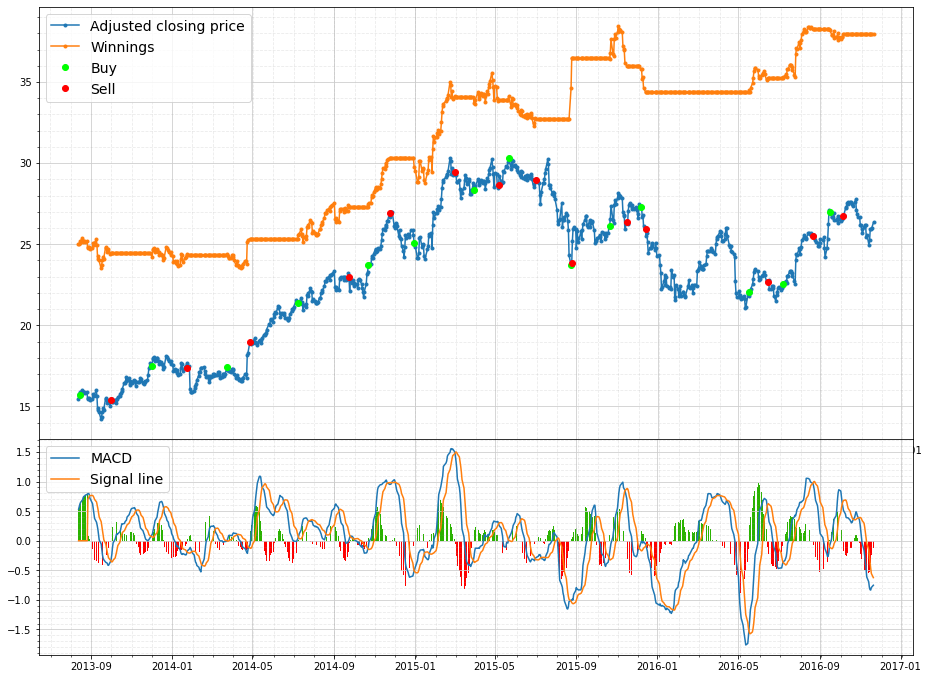

In [26]:
done = False
t.reset()
t.history_manager.reset()
t.stock_manager.reset()
max_lookback = 40
min_lookback = 20
lookback = 30

security_sell = 0.95
security_sell_price = 0
sell = 0.92
highest_price = 0

macd_array = []
macd9_array = []
diff_array = []
has_crossed_from_above_to_below_zero_since_selling = True
has_crossed_from_below_to_above_zero_since_buying = False
buy_low = 0

while done != True:
    closing_prices = t.get_historical_data(27,"close")
    sma9 = np.mean(closing_prices[-9:])
    sma12 = np.mean(closing_prices[-12:])
    sma26 = np.mean(closing_prices[-26:])
    
    sma12_y = np.mean(closing_prices[-13:-1])
    sma26_y = np.mean(closing_prices[-27:-1])
    
    macd = sma12 - sma26
    macd9 = 0
    if len(macd_array) > 9:
        macd9 = np.mean(macd_array[-9:])
        
    diff = macd - macd9
    diff_array.append(diff)
    if macd < 0 and  len(macd_array) > 1 and macd_array[-1] > 0:
        has_crossed_from_above_to_below_zero_since_selling = True
    elif macd > 0 and len(macd_array) > 1 and macd_array[-1] < 0:
        has_crossed_from_below_to_above_zero_since_buying = True
    macd_array.append(macd)
    macd9_array.append(macd9)
    macd_y = sma12_y - sma26_y
    if len(diff_array) > 2 and diff > 0: 
        if not t.is_invested() and has_crossed_from_above_to_below_zero_since_selling:
            t.buy()
            security_sell_price = t.todays_price()["open"] * security_sell
            has_crossed_from_below_to_above_zero_since_buying = False
            buy_low = macd
        if t.is_invested() and macd < buy_low:
            t.sell()
            has_crossed_from_above_to_below_zero_since_selling = False
            t.cancel_stop_market_order()
            print("Stop-Loss")
            
            
    if t.is_invested()  and len(diff_array) > 2 and diff < 0 and has_crossed_from_below_to_above_zero_since_buying:
    #    if t.todays_price()["open"] > security_sell_price:
        t.sell()
        has_crossed_from_above_to_below_zero_since_selling = False
            #t.cancel_stop_market_order()
     #   else:
            ## try to come out wih less losses 
      #      t.stop_market_order(security_sell_price)
            #t.sell()
    done = t.next_day( )
    

fig = plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(3, 1,
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

ax1 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[2,0])

t.plot(ax1)
t.current_day = 0
t.history_manager.reset()
t.stock_manager.reset()
#axs[2].figure(figsize=(18,9))
ax2.plot( t.date_keys,macd_array, "-", label="MACD")
ax2.plot( t.date_keys,macd9_array, "-", label="Signal line")

positive_labeles = []
positive_values = []

negative_labeles = []
negative_values = []

for i in range(len(diff_array)):
    value = diff_array[i]
    if value > 0:
        positive_labeles.append(t.date_keys[i])
        positive_values.append(value)
    else:
        negative_labeles.append(t.date_keys[i])
        negative_values.append(value)
        
ax2.bar( positive_labeles, positive_values, color="#2ab300")
ax2.bar( negative_labeles, negative_values, color="#FF0000")

#axs[2].xlabel("Date")

ax2.legend(fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(b=True, which='major',color='#CCCCCC')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
#axs[2].show()

# Mean reverse 

## RSI

Buy Date: 2013-09-17 00:00:00
Sell Date: 2013-10-21 00:00:00
Buy Date: 2014-02-06 00:00:00
Sell Date: 2014-02-19 00:00:00
Buy Date: 2014-04-15 00:00:00
Sell Date: 2014-04-29 00:00:00
Buy Date: 2014-12-16 00:00:00
Sell Date: 2015-02-06 00:00:00
Buy Date: 2015-03-16 00:00:00
Sell Date: 2015-04-28 00:00:00
Buy Date: 2015-06-17 00:00:00
Sell Date: 2015-10-26 00:00:00
Buy Date: 2015-12-16 00:00:00
Sell Date: 2016-03-04 00:00:00
Buy Date: 2016-04-27 00:00:00
Sell Date: 2016-05-26 00:00:00
Buy Date: 2016-06-20 00:00:00
Sell Date: 2016-07-18 00:00:00
Buy Date: 2016-09-12 00:00:00
Sell Date: 2016-09-30 00:00:00
Buy Date: 2016-11-02 00:00:00
Sharp Ratio Stock: 0.6475976568682366
Sharp Ratio Strategy: 0.7565988433338898
Anual return stock: 17.66898366050549%
Anual return: 12.000456907327116%
Winning trades: 8
Loosing trades: 2


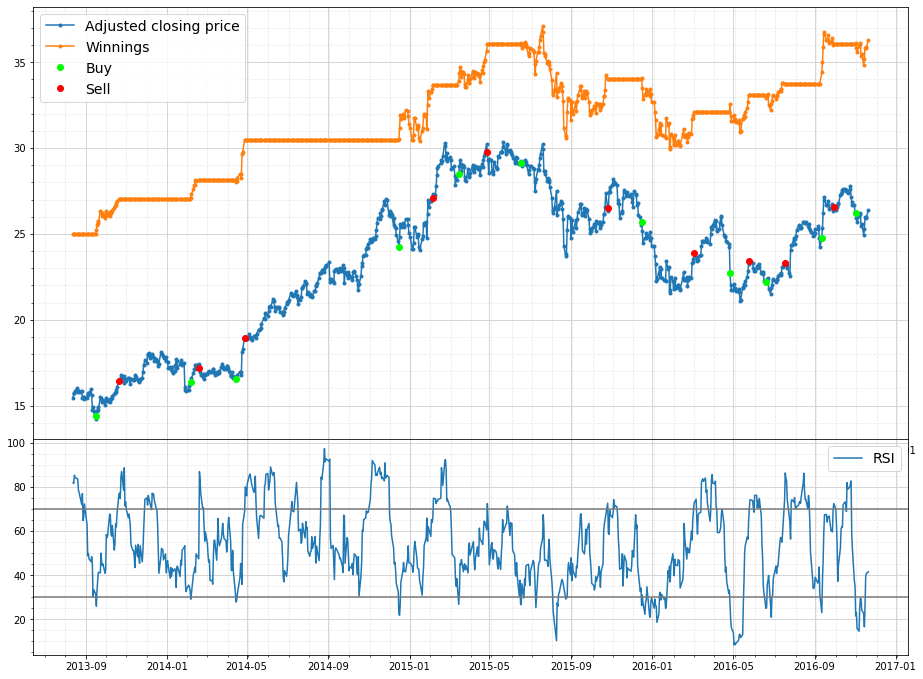

In [27]:
done = False
t.reset()
t.history_manager.reset()
t.stock_manager.reset()
max_lookback = 40
min_lookback = 20
lookback = 30

rsi_array = []

security_sell = 0.98
security_sell_price = 0
sell = 0.92
rsi_period = 14
highest_price = 0

while done != True:
    closing_prices = t.get_historical_data(rsi_period+1,"close")
    pos_profits = 0
    neg_profits = 0
    ## calc RSI 
    for i in range(1,rsi_period+1):
        profit = (closing_prices[i]-closing_prices[i-1])/closing_prices[i]
        if ( profit > 0 ):
            pos_profits = pos_profits + profit
        else:
            neg_profits = neg_profits - profit
    
    
    pos_profits = pos_profits/rsi_period
    neg_profits = neg_profits/rsi_period
    rsi = pos_profits/(pos_profits+neg_profits) * 100
    rsi_array.append(rsi)
    if not t.is_invested() and rsi < 30 :
        t.buy()
        security_sell_price = t.todays_price()["open"] * security_sell
       # t.stop_market_order(security_sell_price)
        highest_price = t.todays_price()["open"]
    if t.is_invested():
        if rsi > 70:
            t.sell()
            #t.cancel_stop_market_order()
        #if closing_prices[-1] > highest_price
        #    highest_price = closing_prices[-1]
        #    sell_price = closing_prices[-1] * sell
        #    if ( sell_price > security_sell_price ):
        #        t.stop_market_order(sell_price)
    
    
    done = t.next_day()

fig = plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(3, 1,
         wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845) 

ax1 = plt.subplot(gs[0:2,0])
ax2 = plt.subplot(gs[2,0])

t.plot(ax1)
t.current_day = 0
t.history_manager.reset()
t.stock_manager.reset()

#plt.figure(figsize=(18,9))
ax2.plot( t.date_keys,rsi_array, "-", label="RSI")
ax2.axhline(y=30, color='#777777', linestyle='-')
ax2.axhline(y=70, color='#777777', linestyle='-')

#ax2.xlabel("Date")
#ax2.ylabel("Closing Price")

ax2.legend(fontsize=14)
ax2.legend(fontsize=14)
ax2.grid(b=True, which='major',color='#CCCCCC')
ax2.minorticks_on()
ax2.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
#ax2.show()

## AI 

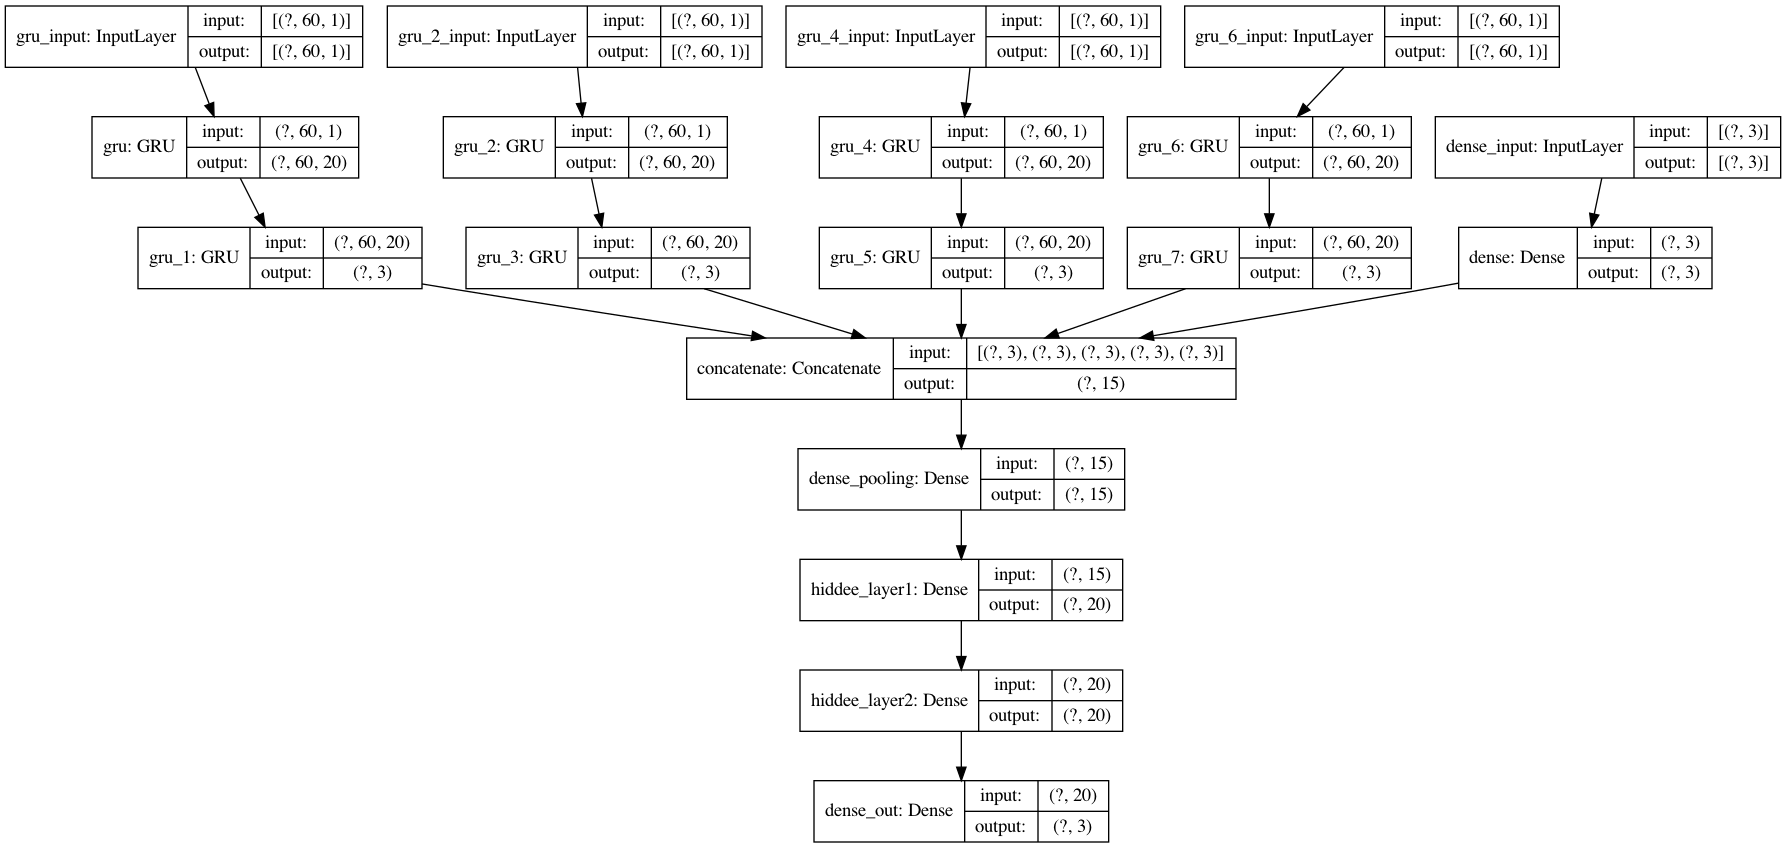

In [29]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.utils import plot_model


close_price_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[60, 1]),
    keras.layers.GRU(3),
])
open_price_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[60, 1]),
    keras.layers.GRU(3),
])
high_price_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[60, 1]),
    keras.layers.GRU(3),
])
low_price_model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[60, 1]),
    keras.layers.GRU(3),
])

# invested stocks, average buy price, opening price today
technical_data = keras.models.Sequential([
    keras.layers.Dense(units=3,input_shape=[3,]),
])



combined =  keras.layers.concatenate([close_price_model.output, open_price_model.output, high_price_model.output, low_price_model.output, technical_data.output], name='concatenate')
z = keras.layers.Dense(15, name='dense_pooling')(combined)
z = keras.layers.Dense(20, name='hiddee_layer1')(z)
z = keras.layers.Dense(20, name='hiddee_layer2')(z)
z = keras.layers.Dense(3, activation="sigmoid", name='dense_out')(z)

model = Model(inputs=[close_price_model.input, open_price_model.input, high_price_model.input, low_price_model.input, technical_data.input], outputs=z)
model.compile(loss="mse", optimizer="adam")
plot_model(model,  show_shapes=True, show_layer_names=True)

In [30]:
def trade_one_step(trader, obs, trade_model, loss_fn):
    with tf.GradientTape() as tape:
        outcome = trade_model(obs)
        [[sell, nothing ,buy]] = outcome
        buy = buy.numpy() + np.random.rand()
        sell = sell.numpy() + np.random.rand()
        nothing = nothing.numpy() + np.random.rand()
        action = 1
        if ( buy > sell and buy > nothing ):
            trader.buy()
            action = 2
        elif ( sell > buy and sell > nothing ):
            trader.sell()
            action = 0
    
        if (action == 0 ):
            buy_action = 1
            sell_action = 0
            nothing_action = 1
        elif (action == 2 ):
            buy_action = 0
            sell_action = 1
            nothing_action = 1
        else:
            buy_action = 1
            sell_action = 1
            nothing_action = 0
        buy_target = tf.constant([[1.]]) - tf.cast(buy_action, tf.float32)
        sell_target = tf.constant([[1.]]) - tf.cast(sell_action, tf.float32)
        nothing_target = tf.constant([[1.]]) - tf.cast(sell_action, tf.float32)
        loss = tf.reduce_mean(loss_fn([sell_target,nothing_target,buy_target], outcome))
    grads = tape.gradient(loss, trade_model.trainable_variables)
    reward = 0
    if len(trader.history_manager.stock_price) > 0:
        reward = trader.get_reward()
    else:
        print("NUUULL")
    done = trader.next_day()
    return reward, done, grads

In [31]:
def get_current_features(t):
    closing_prices = np.array([trader.get_historical_data(60,"close")])
    #closing_prices = np.reshape(closing_prices, (closing_prices.shape[0],1))
    #print("hallo")
    #print(closing_prices)
    
    opening_prices = np.array([trader.get_historical_data(60,"open")])
    #opening_prices = np.reshape(opening_prices, (opening_prices.shape[0],1))
    
    low_prices = np.array([trader.get_historical_data(60,"low")])
    #low_prices = np.reshape(low_prices, (low_prices.shape[0],1))
    
    high_prices = np.array([trader.get_historical_data(60,"high")])
    #high_prices = np.reshape(high_prices, (high_prices.shape[0],1))
    
    invested_stocks = t.stock_manager.amount_of_stocks
    last_buy_price = t.last_buy_price
    opening_price_today = t.todays_price()["open"]
    return [closing_prices,opening_prices,low_prices,high_prices,np.array([[invested_stocks,last_buy_price,opening_price_today]])]




In [32]:
def trade_multiple_episodes( trader, n_episodes, n_max_steps, trade_model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        for step in range(n_max_steps):
            obs = get_current_features(trader)
            reward, done, grads = trade_one_step( trader, obs, trade_model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                trader.plot()
                trader.current_day = 0
                trader.reset()
                trader.history_manager.reset()
                trader.stock_manager.reset()
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [33]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [34]:
n_iterations = 100
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [35]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
trader =  TradeMaker("AAPL",5, "","2012-12-31",62, True)


for iteration in range(n_iterations):
    all_rewards, all_grads = trade_multiple_episodes(
        trader, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

